This notebook is based on the [Lagrangian NN tutorial](https://colab.research.google.com/drive/1CSy-xfrnTX28p1difoTA8ulYw0zytJkq).

## The double pendulum

In [1]:
# For the creation of images
#!pip install -U -q Pillow moviepy proglog

In [2]:
import jax
import jax.numpy as jnp
import numpy as np
from jax.experimental.ode import odeint

import matplotlib.pyplot as plt
from functools import partial # reduces arguments to function by making some subset implicit

from jax.example_libraries import stax, optimizers


# visualization
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from moviepy import ImageSequenceClip
from functools import partial
import proglog
from PIL import Image

In [3]:
# Making sure we are using GPU
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

"""
/tmp/ipykernel_38924/3960750258.py:3: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print(xla_bridge.get_backend().platform)""";


/tmp/ipykernel_11813/2814231649.py:3: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print(xla_bridge.get_backend().platform)


gpu


E0704 14:13:17.209274   11813 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.7.1 but source was compiled with: 9.8.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.
E0704 14:13:17.220763   11813 cuda_dnn.cc:522] Loaded runtime CuDNN library: 9.7.1 but source was compiled with: 9.8.0.  CuDNN library needs to have matching major version and equal or higher minor version. If using a binary install, upgrade your CuDNN library.  If building from sources, make sure the library loaded at runtime is compatible with the version specified during compile configuration.


One can follow the [derivation done by Diego Assencio](https://dassencio.org/33) on the Lagrangian formulation of the double pendulum. From this, one observes that the Lagrangian formualtion of the double pendulum becomes

$$
    \mathcal{L} = \frac{1}{2}\left( m_1 + m_2 \right)l^2_1\dot{\theta}^2_1 + \frac{1}{2}m_2l^2_2\dot{\theta}^2_2 + m_2l_1l_2\dot{\theta}_1\dot{\theta}_2\cos(\theta_1-\theta_2) + \left(m_1+m_2\right)gl_1\cos(\theta_1) + m_2gl_2\cos(\theta_2) 
$$

$$
    \mathcal{L} = \frac{1}{2}m_1 l^2_1\dot{\theta}^2_1 + \frac{1}{2}m_2\left(l^2_1\dot{\theta}^2_1 + l^2_2\dot{\theta}^2_2 + 2l_1l_2\dot{\theta}_1\dot{\theta}_2\cos(\theta_1-\theta_2)\right) + \left(m_1+m_2\right)gl_1\cos(\theta_1) + m_2gl_2\cos(\theta_2) 
$$

Where all the terms that do not contain the gravity $g$ belong to the kinetic energy. To obtain the canonical momenta $p_{\theta_j}$ associates with the coordinate $\theta_j$, one just computes $\partial \mathcal{L} / \partial \dot{\theta}_j$.

In [4]:
# Compute the Lagrangian
def get_Lagrangian(q, q_dot, m1=1, m2=1, l1=1, l2=1, g=9.8):
    θ_1, θ_2 = q
    θ_dot_1, θ_dot_2 = q_dot
    
    E_kin_1 = 0.5*m1*jnp.square(l1*θ_dot_1)
    E_kin_2 = 0.5*m2*( jnp.square(l1*θ_dot_1) + jnp.square(l2*θ_dot_2) + 2*l1*l2*θ_dot_1*θ_dot_2*jnp.cos(θ_1-θ_2) )
    
    T = E_kin_1 + E_kin_2
    V = -g*m2*( l1*jnp.cos(θ_1) +  l2*jnp.cos(θ_2) ) - g*m1*l1*jnp.cos(θ_1)
    return T - V

It is possible to assess for the quality of the Lagrangian-NN as there's an analytical solution for this problem. By following Diego's derivation, one observes that

$$
    \displaystyle\frac{d}{dt}
    \left( \begin{matrix} \theta_1 \\[1pt] \theta_2 \\[1pt] \omega_1 \\[1pt] \omega_1 \end{matrix} \right)
    =
    \left( \begin{matrix} \omega_1 \\ \omega_2 \\ g_1(\theta_1,\theta_2,\omega_1,\omega_2)
    \\ g_2(\theta_1,\theta_2,\omega_1,\omega_2) \end{matrix} \right),
$$

where

$$
    g_1 := \displaystyle\frac{f_1 - \alpha_1 f_2}{1 - \alpha_1\alpha_2}
    \quad\quad
    g_2 := \displaystyle\frac{f_2 - \alpha_2 f_1}{1 - \alpha_1\alpha_2}
$$

and

$$
    \begin{align}
    & \alpha_1(\theta_1,\theta_2) ~:=~ \displaystyle\frac{l_2}{l_1}\left(\frac{m_2}{m_1 + m_2}\right)\cos(\theta_1 - \theta_2)\\
    &\alpha_2(\theta_1,\theta_2) ~:=~ \frac{l_1}{l_2}\cos(\theta_1-\theta_2)\\
    &\displaystyle f_1(\theta_1, \theta_2, \dot{\theta}_1, \dot{\theta}_2) ~:=~
    -\frac{l_2}{l_1}\left(\frac{m_2}{m_1+m_2}\right) \dot{\theta}_2^2\sin(\theta_1 - \theta_2)
    - \frac{g}{l_1} \sin\theta_1 \\
    &\displaystyle f_2(\theta_1, \theta_2, \dot{\theta}_1, \dot{\theta}_2) ~:=~
    \frac{l_1}{l_2}\dot{\theta}_1^2\sin(\theta_1-\theta_2) - \frac{g}{l_2} \sin\theta_2 
    \end{align}
$$

These functions will also be computed to then create the loss function. 


In [5]:
def get_analytical_sol(state, t=0, m1=1, m2=1, l1=1, l2=1, g=9.8):
    θ_1, θ_2, θ_dot_1, θ_dot_2 = state
    
    α1 = (l2/l1)*(m2/(m1+m2))*jnp.cos(θ_1-θ_2)
    α2 = (l1/l2)*jnp.cos(θ_1-θ_2)
    
    f1 = -(l2/l1)*(m2/(m1+m2))*jnp.square(θ_dot_2)*jnp.sin(θ_1-θ_2) - g*jnp.sin(θ_1)/l1
    f2 = (l1/l2)*jnp.square(θ_dot_1)*jnp.sin(θ_1-θ_2) - g*jnp.sin(θ_2)/l2
    
    g1 = (f1 - α1*f2)/(1 - α1*α2)
    g2 = (f2 - α2*f1)/(1 - α1*α2)
    
    return jnp.stack([θ_dot_1,θ_dot_2,g1,g2])

The next step is to obtain the dynamics of the system with numerical integration. We take the vectorized form of the Euler-Lagrange equation 

$$
    \ddot q = (\nabla_{\dot q}\nabla_{\dot q}^{\top}\mathcal{L})^{-1}[\nabla_q \mathcal{L} - (\nabla_{q}\nabla_{\dot q}^{\top}\mathcal{L})\dot q]
$$

It is possible to notice that the neural network will depend on the inverse of a Hessian matrix during the forward pass. This is not an easy implementation; however, the authors of the research propose the usage of JAX, which can implement the previous equation straightforwardly. 

In [6]:
def get_eqs_of_motion(L, state, t=None):
    q, q_t = jnp.split(state,2)
    q_tt =  ( jnp.linalg.pinv( jax.hessian(L,1)(q,q_t) ) @ (
                jax.grad(L,0)(q,q_t) - jax.jacobian(( jax.jacobian(L,1) ),0)(q,q_t)@q_t
              )
            )
    return jnp.concatenate([q_t, q_tt])

# Which is equivalent to:
def get_eqs_of_motion__more_simple(L, state, t=None):
    q, q_t = jnp.split(state, 2)
    
    M_inv = jnp.linalg.pinv(jax.hessian(L, 1)(q, q_t))  # ∂²L/∂q̇²
    f = jax.grad(L, 0)(q, q_t)                          # ∂L/∂q
    J = jax.jacobian(jax.grad(L, 1), 0)(q, q_t)         # ∂/∂q (∂L/∂q̇)
    
    q_tt = M_inv @ (f - J @ q_t)
    return jnp.concatenate([q_t, q_tt])

  


def JIT_solve_lagrangian(L, initial_state, **kwargs):
  #         We currently run odeint on CPUs only, because its cost is 
  #         dominated by control flow, which is slow on GPUs.
  @partial(jax.jit, backend='cpu')
  def f(initial_state): # The creation of a pure function.
    return odeint(partial(get_eqs_of_motion, L), initial_state, **kwargs)
  return f(initial_state)

The authors of this tutorial made an elegant, yet compact, representation of the equations of motions. Here, I would like to dwelve more into the meaning of each line. 

**REMARKS** 
* `jax.jacobian(jax.jacobian(L,0)(q,q_t) @ q_t)`: is elegant but dense. It computes ∂/∂q of (∂L/∂q @ q_dot), which is part of the standard Euler-Lagrange equation.
* `jnp.linalg.pinv`: is good for generality, but can sometimes introduce numerical instability. If the system is known to be well-behaved, `jnp.linalg.solve` may be faster and more accurate (but `pinv` is safer for a generic setup like LNN training).


**`get_eqs_of_motion(L, t, state):`** 
* This second-order differentiation handles the time derivative of the partial w.r.t. velocity — that is, it traces how the Lagrangian's "momentum term" evolves.
* The full derivative of the state is returned. The output is in the form of 

$$
    \frac{d}{dt} \begin{bmatrix}
           q \\
           \dot{q} \\
         \end{bmatrix} = \begin{bmatrix}
           \dot{q} \\
           \ddot{q} \\
         \end{bmatrix}
$$

This is now suitable for any ODE solver like `odeint`.


**`solve_lagrangian(L, initial_state, **kwargs):`** this is a wrapper (nested `def`s) that:
1. Fixes the Lagrangian `L` for use in `get_eqs_of_motion`.
2. JIT-compiles the call to `odeint` (using CPU backend due to control flow complexity).

* **Why JIT on CPU?**
  * odeint in JAX has complex control flow (e.g., branching based on tolerances, adaptive step sizes). GPUs handle vectorized math well but can be slower at control flow. So you force it to run on CPU for now.
  * JAX now has better support for GPU control flow via jax.experimental.ode.odeint, but performance gains are still context-dependent.

* **Why use an inner function for `solve_lagrangian` instead of JIT-decorating it directly?** For instance:

```Python
@partial(jax.jit, backend='cpu')
def solve_lagrangian(L, initial_state, **kwargs):
    return odeint(partial(get_eqs_of_motion, L), initial_state, **kwargs)
```

Both versions can work… BUT there’s a subtle difference in JAX tracing behavior and Python flexibility.

1. **JAX JIT requires static arguments.**
  * JAX's `@jit` compiler likes arguments to be **static or immutable** — e.g., the function `L` or other Python-side closures.
  * When you decorate the whole function `solve_lagrangian(...)` with `@jit`, `L` and `**kwargs` become part of the JAX tracing process.
  * This can lead to **recompilation** every time you pass a different `L`, or even worse — a `TypeError` if `L` isn't a JAX-friendly object (e.g., a function or closure it can’t serialize).

UNDERSTAND: Using an inner function like this:
```Python
@partial(jax.jit, backend='cpu')
def f(initial_state):
```
  * fixes `L` and `**kwargs` outside the JIT scope. **That makes `f` a pure function of `initial_state`**, which is safer and more efficient for JAX's tracer.
    * Remember this was something mentioned in the KTH school.

2. **THIS IS ACTUALLY A CLEANER COMPILATION**

With this pattern:

```Python
def solve_lagrangian(L, initial_state, **kwargs):
    @partial(jax.jit, backend='cpu')
    def f(initial_state):
        ...
```
one:
* Avoid JAX tracing the `L` function directly
* **Minimize the number of recompilations when calling `solve_lagrangian` multiple times**
* Keep the outer function Pythonic and flexible (e.g., you could swap in different `L`s dynamically)

3. **EASIER DEBUGGING**
* If you put the `@jit` on the outer function, debugging becomes harder, especially if something goes wrong inside the call to `odeint`. If it's wrapped in `f(...)`, you can:
  * Call the inner function un-jitted for debugging
  * **Catch errors before JAX compiles everything**

4. **REMEMBER**: You want **clean**, JIT-optimized computation **of just the numerical function** (not the logic/structure).
* So yep — both can work, but the version with the inner function is safer, cleaner, and more efficient for dynamically passed Lagrangians or kwargs.



    
 

## WHAT IS JIT AND WHY IS IT SO IMPORTANT?

JIT stands for Just-In-Time compilation. It means: **Instead of interpreting your code line by line (like Python normally does), JIT compiles the code into optimized machine instructions at runtime, right before it's executed.**

In JAX:

```Python
@jax.jit
def f(x):
    return x**2 + jnp.sin(x)
```

When you call f(x), JAX:

* Traces the function to record the operations it does (like a computation graph).
* Compiles those operations into fast **XLA code** (XLA = Accelerated Linear Algebra compiler).
* Caches the compiled version so that next time it just runs the optimized code.

Thanks to JIT:

* You get C/C++-level speed (or better, especially on GPU).
* You avoid Python overhead (e.g., no type checking, no Python object boxing/unboxing).
* You can run code efficiently on **CPU**, **GPU**, or **TPU**.

**🧩 How does this compare to Fortran or C++?**

| Feature           | Python (standard) | JAX with JIT                | Fortran / C++         |
| ----------------- | ----------------- | --------------------------- | --------------------- |
| Language type     | Interpreted       | Interpreted + JIT           | Compiled              |
| Compilation step? | ❌ (usually none)  | ✅ JIT with XLA              | ✅ Ahead-of-Time  (compiled before execution)       |
| Performance       | 🐢 Slow           | 🚀 Near C-level speed       | 🚀 Fast               |
| Flexibility       | ✅ Very high       | ✅ High (JIT has limits)     | ❌ Less flexible       |
| Compilation time  | None              | JIT happens *on first call* | Happens at build time |

**🧩 What does @partial(...) do?**

The @partial decorator comes from Python's functools module and is used to pre-fill some arguments of a function, effectively locking in some parameters ahead of time.

In other words, it returns a new version of a function with some arguments already fixed. For instance: 

```Python
from functools import partial

def f(a, b, c):
    return a + b + c

g = partial(f, b=2)
g(a=1, c=3)  # returns 1 + 2 + 3 = 6
```

**🧩 Why do we use `@partial` with decorators like `@jax.jit`?**

When you decorate a function like this:

```Python
@partial(jax.jit, backend='cpu')
def f(x):
    return ...
```

That’s exactly the same as:

```Python

f = partial(jax.jit, backend='cpu')(f)
```

You're passing `backend='cpu'` as a pre-filled argument to `jax.jit`. So:
* `jax.jit` is a function that returns a **decorator**
* `partial(jax.jit, backend='cpu')` becomes a customized decorator
* `@partial(...)` is just the decorator version of `partial(...)`


### Setting up helper functions for the dynamics of the system. 


In [7]:
# PROGRAMMING OPTIMIZATION
# Double pendulum dynamics via the rewritten Euler-Lagrange
@partial(jax.jit, backend='cpu')
def JIT_solve_autograd(initial_state, times, m1=1, m2=1, l1=1, l2=1, g=9.8):
  L = partial(get_Lagrangian, m1=m1, m2=m2, l1=l1, l2=l2, g=g)
  return JIT_solve_lagrangian(L, initial_state, t=times, rtol=1e-10, atol=1e-10)

# Double pendulum dynamics via analytical forces taken from Diego's blog
@partial(jax.jit, backend='cpu')
def JIT_solve_analytical(initial_state, times):
  return odeint(get_analytical_sol, initial_state, t=times, rtol=1e-10, atol=1e-10)

In [8]:
# TESTING SOLUTIONS
def normalize_dp(state):
  # wrap generalized coordinates to [-pi, pi]
  return jnp.concatenate([(state[:2] + np.pi) % (2 * np.pi) - np.pi, state[2:]])

def rk4_step(f, x, t, h):
  # one step of runge-kutta integration
  k1 = h * f(x, t)
  k2 = h * f(x + k1/2, t + h/2)
  k3 = h * f(x + k2/2, t + h/2)
  k4 = h * f(x + k3, t + h)
  return x + 1/6 * (k1 + 2*k2 + 2*k3 + k4)

**WHY normalize the variables?**
The angles $\theta_1$ and $\theta_2$ in a pendulum are periodic — meaning:
* $\theta = \pi \rightarrow \theta = -\pi$
* $\theta = 2\pi \rightarrow \theta = 0$

**But numerically, they are not treated the same** unless you explicitly wrap or normalize them. This helps:
* Avoid large angle drift (e.g., 20 radians vs. 1 radian)
* Make trajectory comparisons clearer
* Most importantly: **Improve numerical stability**

### **NEXT:**  Compare Autograd vs. Analytic solutions

Now that we have the Euler-Lagrange equation, one can use automatic differentiation to obtain the dynamics of the system; this approach must match the analytic solution.To test this, the authors opt for a random initial state, then the analytic solution is slightly perturbed to assess how sensitive it is to initial conditions. The latter will help in assessing the quality of performance of autograd. 


In [9]:
# choose an initial state
x0 = np.array([3*np.pi/7, 3*np.pi/4, 0, 0], dtype=np.float32)
noise = np.random.RandomState(0).randn(x0.size)
t = np.linspace(0, 40, num=401, dtype=np.float32)

In [10]:
# Compute dynamics analytically
x_analytical = jax.device_get(JIT_solve_analytical(x0,t))
noise_coeff_1, noise_coeff_2 = 1e-10, 1e-11
x_perturbed_1 = jax.device_get(JIT_solve_analytical(x0 + noise_coeff_1*noise, t))
x_perturbed_2 = jax.device_get(JIT_solve_analytical(x0 + noise_coeff_2*noise, t))

In [11]:
# compute dynamics via autograd / the rewritten E-L equation
x_autograd = jax.device_get(JIT_solve_autograd(x0, t))

Let's compare methods

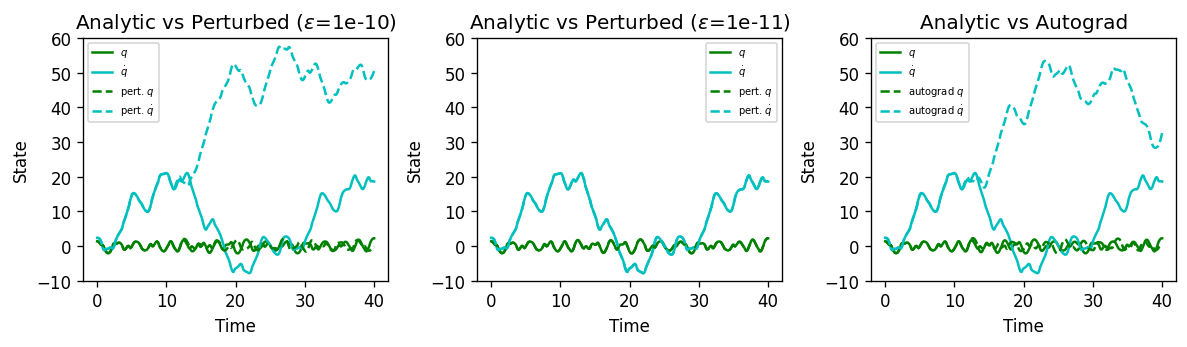

In [22]:
plt.figure(figsize=[10,3], dpi=120) #; plt.xlim(0, 100)
plt.subplot(1,3,1)
plt.title("Analytic vs Perturbed ($\epsilon$={})".format(noise_coeff_1))
plt.xlabel("Time") ; plt.ylabel("State")
plt.plot(t, x_analytical[:, 0], 'g-', label='$q$')
plt.plot(t, x_analytical[:, 1], 'c-', label='$\dot q$')
plt.plot(t, x_perturbed_1[:, 0], 'g--', label='pert. $q$')
plt.plot(t, x_perturbed_1[:, 1], 'c--', label='pert. $\dot q$')
plt.ylim(-10, 60)
plt.legend(fontsize=6)

plt.subplot(1,3,2)
plt.title("Analytic vs Perturbed ($\epsilon$={})".format(noise_coeff_2))
plt.xlabel("Time") ; plt.ylabel("State")
plt.plot(t, x_analytical[:, 0], 'g-', label='$q$')
plt.plot(t, x_analytical[:, 1], 'c-', label='$\dot q$')
plt.plot(t, x_perturbed_2[:, 0], 'g--', label='pert. $q$')
plt.plot(t, x_perturbed_2[:, 1], 'c--', label='pert. $\dot q$')
plt.ylim(-10, 60)
plt.legend(fontsize=6)

plt.subplot(1,3,3)
plt.title("Analytic vs Autograd")
plt.xlabel("Time") ; plt.ylabel("State")
plt.plot(t, x_analytical[:, 0], 'g-', label='$q$')
plt.plot(t, x_analytical[:, 1], 'c-', label='$\dot q$')
plt.plot(t, x_autograd[:, 0], 'g--', label='autograd $q$')
plt.plot(t, x_autograd[:, 1], 'c--', label='autograd $\dot q$')
plt.ylim(-10, 60)
plt.legend(fontsize=6)

plt.tight_layout() ; plt.show()